<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-данных-свечей" data-toc-modified-id="Получение-данных-свечей-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение данных свечей</a></span></li><li><span><a href="#Добавление-индикаторов" data-toc-modified-id="Добавление-индикаторов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Добавление индикаторов</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Пересечение-скользящих-средних" data-toc-modified-id="Пересечение-скользящих-средних-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Пересечение скользящих средних</a></span></li><li><span><a href="#Ресэмплирование" data-toc-modified-id="Ресэмплирование-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ресэмплирование</a></span></li></ul></li><li><span><a href="#Мой-портфель" data-toc-modified-id="Мой-портфель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Мой портфель</a></span></li><li><span><a href="#Тестирование-на-исторических-данных" data-toc-modified-id="Тестирование-на-исторических-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование на исторических данных</a></span><ul class="toc-item"><li><span><a href="#Визуализация" data-toc-modified-id="Визуализация-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Визуализация</a></span></li></ul></li></ul></div>

In [97]:
import pandas as pd
import open_finam_data
from datetime import datetime
import numpy as np

In [194]:
# НАстройка отображения графиков
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 12)


## Получение данных свечей

In [332]:
tolls_path_list = ['HYDR_200101_200425.csv','YNDX_200101_200425.csv']
df_dikt = {}
for toll_path in tolls_path_list:
    df = open_finam_data.open('../../input/' + toll_path)
    #  Фильтр дат
    df = df.loc[df.index >= '2020-04-10']
    df_dikt[toll_path.split('_')[0]] = df

In [333]:
df= df_dikt['HYDR']
df

,OPEN,HIGH,LOW,CLOSE,VOL
DATE_TIME,,,,,
2020-04-10 10:01:00,0.6330,0.6330,0.6281,0.6293,14127000
2020-04-10 10:02:00,0.6292,0.6307,0.6292,0.6307,4682000
2020-04-10 10:03:00,0.6299,0.6322,0.6297,0.6312,4030000
2020-04-10 10:04:00,0.6318,0.6325,0.6312,0.6321,3683000
2020-04-10 10:05:00,0.6318,0.6324,0.6318,0.6321,1033000
...,...,...,...,...,...
2020-04-24 18:40:00,0.6145,0.6154,0.6145,0.6149,3493000
2020-04-24 18:46:00,0.6118,0.6118,0.6118,0.6118,38239000
2020-04-24 18:47:00,0.6118,0.6118,0.6118,0.6118,759000


## Добавление индикаторов

### Скользящее среднее

In [334]:
for df_toll in list(df_dikt):
    df_dikt[df_toll]['ma_samp_100'] = df.CLOSE.rolling(window = 800, min_periods=800).mean()
    df_dikt[df_toll]['ma_samp_10'] = df.CLOSE.rolling(window = 100, min_periods=100).mean()

### Пересечение скользящих средних

In [336]:
i = 2
for df_toll in list(df_dikt):
    ma_difference = []
    for index in range(len(df_dikt[df_toll].index)):
        ma_difference.append(df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'ma_samp_100'] - df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'ma_samp_10'])
        if index < i: continue
        ma_sum = ma_difference[-1] + ma_difference[-1-i]
        peresech = abs(ma_sum) < abs(ma_difference[-1]) and abs(ma_sum) < abs(ma_difference[-1-i])
    #     if peresech == True: print(df_test.index[index])
        df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'SIGNAL'] = peresech
        df_dikt[df_toll].loc[df_dikt[df_toll].index[index], 'POZISION'] = 'short' if ma_difference[-1] > 0 else 'long'
df_dikt['HYDR'][df_test.SIGNAL == True]

,OPEN,HIGH,LOW,CLOSE,VOL,ma_samp_100,ma_samp_10,SIGNAL,POZISION
DATE_TIME,,,,,,,,,
2020-04-16 13:34:00,0.6080,0.6088,0.6080,0.6088,241000,0.605072,0.605124,True,long
2020-04-20 13:38:00,0.6117,0.6117,0.6110,0.6110,1015000,0.614817,0.614739,True,short
2020-04-21 17:33:00,0.6159,0.6161,0.6148,0.6154,1320000,0.604479,0.604636,True,long
2020-04-23 15:38:00,0.6306,0.6306,0.6306,0.6306,32000,0.629789,0.629803,True,long
2020-04-24 10:27:00,0.6262,0.6266,0.6249,0.6258,3422000,0.629404,0.629355,True,short


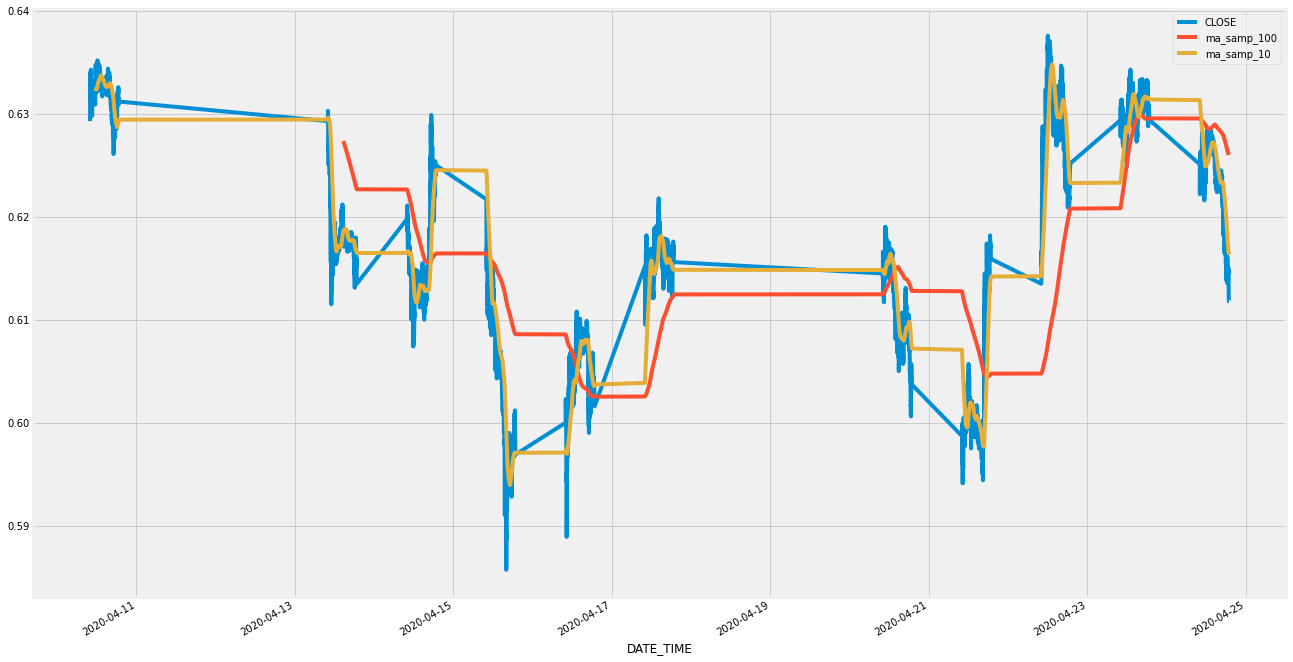

In [337]:
df_dikt['HYDR'].loc[:,['CLOSE','ma_samp_100','ma_samp_10']].plot()

# Определяем период который перекрывают все инструменты

In [338]:
data_period_dick = {'stert':[], 'end':[], 'step' : []}
for tool in list(df_dikt):
    data_period_dick['stert'].append(df_dikt[tool].index[0])
    data_period_dick['end'].append(df_dikt[tool].index[-1])
    data_period_dick['step'].append(df_dikt[tool].index[1] - df_dikt[tool].index[0])
data_period_dick['stert'] = max(data_period_dick['stert'])
data_period_dick['end'] = min(data_period_dick['end'])
data_period_dick['step'] = data_period_dick['step'][0]
data_period_dick

{'stert': Timestamp('2020-04-10 10:01:00'),
 'end': Timestamp('2020-04-24 18:48:00'),
 'step': Timedelta('0 days 00:01:00')}

In [339]:
# Словарь с котировами по цене закрытия на инструменты нахдящиеся в работе
cot_dict = {}
for tool in list(df_dikt):
    cot_dict[tool] = 0
cot_dict

{'HYDR': 0, 'YNDX': 0}

### Ресэмплирование

In [340]:
# Превщение последовательный временной датафрейм
for tool in list(df_dikt):
    df_dikt[tool] = df_dikt[tool].resample(data_period_dick['step']).last()

In [341]:
# Создание диапазана для отдельного использования
data_time_range = pd.date_range(start = data_period_dick['stert'], end = data_period_dick['end'], freq = data_period_dick['step'])

## Мой портфель

In [342]:
# Создание данных о стоимости портфеля
portfel_df = pd.DataFrame(index=data_time_range)
portfel_df['Portfel_vol'] = portfel_df.apply(lambda x: 0, axis = 1)

## Тестирование на исторических данных

In [352]:
import financial_account
my_account = financial_account.Financial_account()
my_account.add_mone(100000)
data_null = data_time_range[0]
data_prise = data_null

for data_time in data_time_range:
#   Определение акруальных котировок
    for tool in list(cot_dict):
        if data_time == pd.Timestamp('2020-04-23 15:38:00'): continue
        cot_dict[tool] = df_dikt[tool].iloc[df_dikt[tool].index == data_time]['CLOSE'].values[0]
        if tool == 'HYDR':
            if df_dikt[tool].loc[data_time, 'SIGNAL'] != True: continue
            if df_dikt[tool].loc[data_time, 'POZISION'] == 'long':
                my_account.buy_lot(lot_name = tool,lot_count = 10, lot_size = 1000, lot_price = cot_dict[tool])
            if df_dikt[tool].loc[data_time, 'POZISION'] == 'short':
                my_account.sell_lot(lot_name = tool,lot_count = 10, lot_size = 1000, lot_price = cot_dict[tool])
        
    portfel_df.loc[portfel_df.index == data_time] = my_account.get_portfel_price(cot_dict)

portfel_df[-2:]



,Portfel_vol
2020-04-24 18:47:00,94015.053682
2020-04-24 18:48:00,94015.053682


### Визуализация

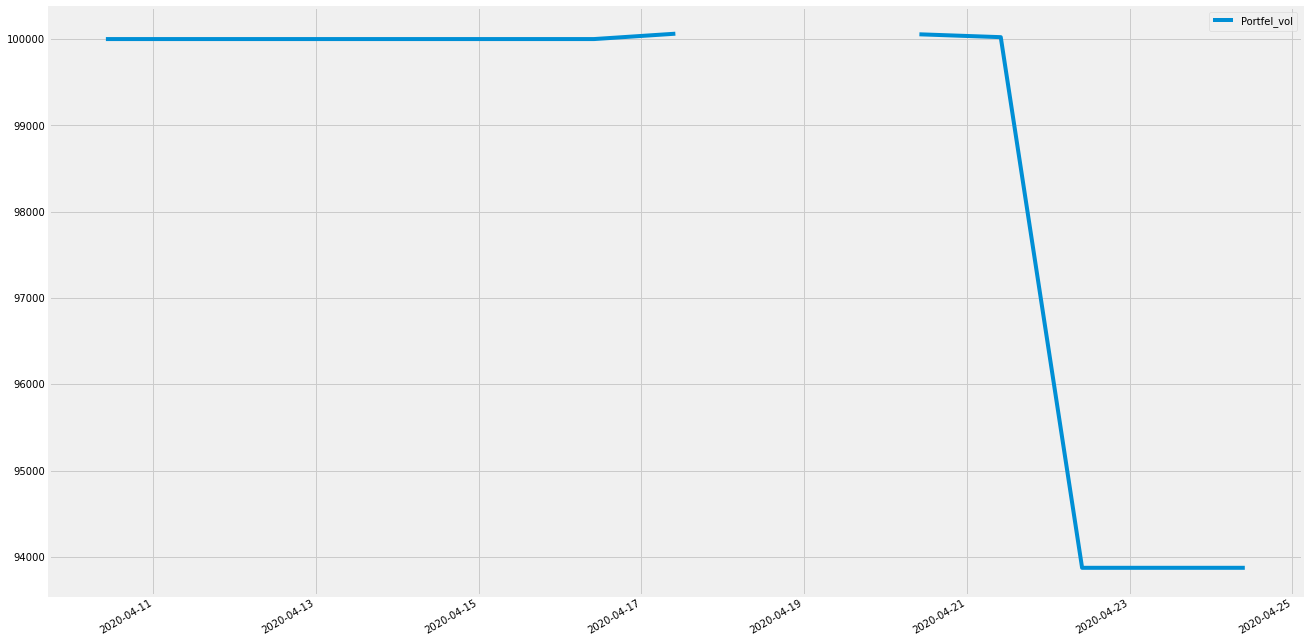

In [351]:
portfel_df.asfreq('D').plot()